In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 500)

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [3]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [4]:
import tensorflow as tf
import tensorflow.keras as keras

tf.__version__

'2.3.0'

In [5]:
file = r'C:\Users\ \Desktop\DMML2\fireweather.csv'

dataframe = pd.read_csv(file)

C:\Users\Jack Dunne\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:

# creating a boolean fire variable
dataframe["fire_size"].fillna("nan",inplace=True)
def map_fire(fire_size):
  if fire_size != 'nan':
    return 1
  else:
    return 0

dataframe['fire'] =  dataframe["fire_size"].apply(lambda fire_size: map_fire(fire_size))


# mapping months to the date variable
months_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12' ]

def map_month(month):
    for i in months_list:
        if month == i:
            return i

dataframe['months'] =  dataframe["date"].str[5:7].apply(lambda month: map_month(month))

In [7]:
columns_to_remove = [ 'latitude_fire', 'longitude_fire', 'frp', 'daynight', 
                     'region', 'name', 'stationID', 'brightness', 'scan', 
                     'track', 'acq_time', 'satellite', 'confidence', 'bright_t31', 
                     'type', 'Fire_number', 'date']

dataframe.drop(columns_to_remove, axis=1, inplace=True)

In [8]:
dataframe

,tavg,tmin,tmax,prcp,wdir,wspd,pres,latitude_weather,longitude_weather,elevation,dslr,fire_size,fire_size_bin,fire,months
0,29.4,22.8,36.8,31.2,177.6,14.0,1015.1,-14.3000,126.600,29.0,0,nan,NaN,0,01
1,29.7,24.3,37.2,0.0,177.6,14.0,1015.1,-14.3000,126.600,29.0,1,nan,NaN,0,01
2,29.5,25.4,37.0,0.4,254.0,12.2,1004.3,-14.3000,126.600,29.0,2,nan,NaN,0,01
3,29.4,23.4,35.1,33.8,266.0,15.0,1004.2,-14.3000,126.600,29.0,0,nan,NaN,0,01
4,28.6,21.2,33.0,14.0,268.0,11.8,1005.2,-14.3000,126.600,29.0,0,nan,NaN,0,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254514,15.6,11.1,22.4,0.0,163.0,31.1,1019.7,-37.0717,142.741,246.0,8,nan,NaN,0,12
254515,18.8,11.1,27.6,0.0,166.0,18.7,1017.8,-37.0717,142.741,246.0,9,nan,NaN,0,12
254516,20.4,10.8,30.3,0.0,190.0,11.4,1015.9,-37.0717,142.741,246.0,10,nan,NaN,0,12
254517,24.3,11.5,35.0,0.0,257.0,9.8,1012.4,-37.0717,142.741,246.0,11,nan,NaN,0,12


## Training/Testing Models

In [9]:
dataframe.columns

Index(['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'latitude_weather', 'longitude_weather', 'elevation', 'dslr',
       'fire_size', 'fire_size_bin', 'fire', 'months'],
      dtype='object')

In [10]:
fire_preds = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'latitude_weather', 'longitude_weather', 'elevation', 'dslr', 'months', 'fire']


subset = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'latitude_weather', 'longitude_weather', 'elevation', 'dslr', 'months']

numerical_features = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'latitude_weather', 'longitude_weather', 'elevation', 'dslr']


train_test_df = dataframe[fire_preds]
train_test_df = train_test_df.dropna()

sample_df = train_test_df.sample(frac=1, random_state=1)

X = sample_df[subset]
y = sample_df['fire']


#### Fixing Class imbalance - Undersampling

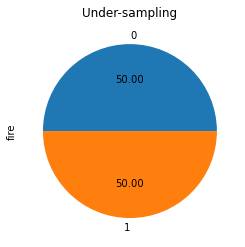

In [11]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
X_res, y_res = rus.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [12]:
y_res.value_counts()

0    22094
1    22094
Name: fire, dtype: int64

In [13]:
dataframe = X_res.join(y_res)
dataframe

,tavg,tmin,tmax,prcp,wdir,wspd,pres,latitude_weather,longitude_weather,elevation,dslr,months,fire
0,27.6,23.0,31.4,0.0,346.0,17.9,1010.6,-17.7333,139.5333,6.0,38,09,0
1,22.6,22.5,25.2,3.4,341.0,17.1,1008.8,-25.3000,152.9000,18.0,0,10,0
2,21.4,10.3,33.0,0.0,63.0,14.9,1013.8,-33.0000,121.6000,249.0,11,01,0
3,11.8,6.9,18.0,0.0,58.0,7.7,1024.7,-32.0975,115.8810,30.0,1,07,0
4,21.9,20.9,24.5,0.0,129.0,12.3,1017.2,-23.5000,151.3000,20.0,1,04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44183,24.3,18.1,31.7,0.0,111.0,8.8,1012.5,-12.7000,132.9000,26.0,10,06,1
44184,15.1,6.9,23.0,0.0,194.0,8.1,1020.5,-31.0000,148.4000,184.0,1,04,1
44185,16.9,13.0,22.4,0.0,68.0,12.7,1026.7,-32.7167,148.1833,267.0,21,05,1
44186,15.6,8.3,20.8,0.0,180.0,11.0,1023.2,-34.2000,142.1000,50.0,33,04,1


### splitting into test train val

In [14]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.70*len(dataframe)), int(0.80*len(dataframe))])

In [15]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

30931 training examples
4419 validation examples
8838 test examples


In [16]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('fire')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [17]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-16-fed0a3667602>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [18]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of months:', train_features['months'])
print('A batch of targets:', label_batch )

Every feature: ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'latitude_weather', 'longitude_weather', 'elevation', 'dslr', 'months', 'fire']
A batch of months: tf.Tensor(
[[b'05']
 [b'08']
 [b'06']
 [b'12']
 [b'01']], shape=(5, 1), dtype=string)
A batch of targets: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


In [19]:
from tensorflow.keras import layers

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [20]:
photo_count_col = train_features['wdir']
layer = get_normalization_layer('wdir', train_ds)
layer(photo_count_col)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'Normalization'

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
test_type_col = train_features['months']
test_type_layer = get_category_encoding_layer(name='months',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [ ]:
categorical_cols = ['months']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

### neural net aspect

In [ ]:
p = .1

all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dropout(p)(all_features)
x = tf.keras.layers.Dense(100, activation='relu')(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(p)(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(p)(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(p)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

In [ ]:
model = tf.keras.Model(all_inputs, out)

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), ]# precision-recall curve

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=metrics)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [ ]:
model.summary()

In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
plot_loss(history, "Zero Bias", 0)


In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
plot_metrics(history)


In [ ]:
y_pred = model.predict(test_ds)
y_pred = (y_pred>0.5)
y_pred

In [ ]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test

In [ ]:
cm = confusion_matrix(example, y_pred)
cm

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

In [ ]:
recall = recall_score(y_test, y_pred)
recall

In [ ]:
final = classification_report(y_test, y_pred)
print(final)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Naive Bayes ROC curve')
plt.show()